In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import re
import string
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
    
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, Conv1D, Dense, Dropout, Attention, Bidirectional
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import nltk
nltk.download('stopwords')
log_dir = "logs/"  # Especifique o diretório onde os logs serão armazenados
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gyova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
df = pd.read_csv('../data/fakeBr.csv')
df = df.drop(columns=['index'])
df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [24]:
stop_words = set(stopwords.words('portuguese'))

def remover_stop_words(news):
    palavras = news.split()
    palavras_sem_stop = [palavra for palavra in palavras if palavra.lower() not in stop_words]
    return ' '.join(palavras_sem_stop)

def review_cleaning(text):
    
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df["preprocessed_news"] = df["preprocessed_news"].apply(remover_stop_words)
df['label'] = df.apply(lambda row: 0 if row.label == 'fake' else 1, axis=1)
X = df.drop(['label'], axis = 1)
Y = df['label']


In [25]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, stratify=Y)
X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())
X_test = X_test['preprocessed_news'].apply(lambda x: x.lower())

In [26]:
#variaveis dos modelos
maxlen=256
num_words = 8000
batch_size = 128 
epochs = 20 
validation_fraction = 0.2
output_dim = 64



early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [27]:
train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>',num_words=num_words)
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index
train_sequences = train_tokenizer.texts_to_sequences(X_train)

text_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>',num_words=num_words)
text_tokenizer.fit_on_texts(X_test.values)
text_word_index = text_tokenizer.word_index
text_sequences = text_tokenizer.texts_to_sequences(X_test)

vocab_length = len(train_word_index) + 1

train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=maxlen)
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=maxlen)

train_padded_seqeunces = train_padded_seqeunces[:, :, tf.newaxis]
test_padded_seqeunces = test_padded_seqeunces[:, :, tf.newaxis]

x_train_padded_seqeunces = train_padded_seqeunces[:, :, tf.newaxis]
x_test_padded_seqeunces = test_padded_seqeunces[:, :, tf.newaxis]

vectorizer = CountVectorizer(max_features=num_words)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train).toarray()

vectorizer = CountVectorizer(max_features=num_words)
vectorizer.fit(X_test)
X_test = vectorizer.transform(X_test).toarray()

In [28]:

with open('../models/MLPClassifierWithGridSearchCV.pkl', 'rb') as arquivo:
    clf = pickle.load(arquivo)
    
modelLSTM = load_model('../models/modelLSTM.keras')
modelHAN = load_model('../models/modelHAN.keras')


#### MLP

Inicio do Teste
Matriz de confusão


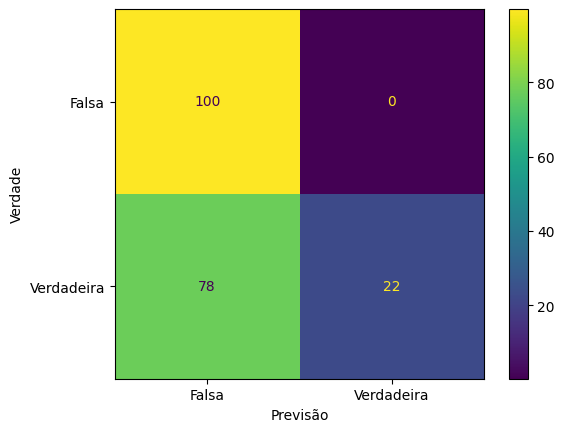

Fim do Teste


In [29]:

print("Inicio do Teste")
y_test_pred = clf.predict(X_test)
y_test_pred = (y_test_pred > 0.70)
mlp_acc = round(accuracy_score(y_test, y_test_pred), 2)

cm = confusion_matrix(y_test, y_test_pred)

print("=" * 20)
print("Matriz de confusão")
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=['Falsa','Verdadeira'])

disp.plot( values_format='.0f')
disp.ax_.set(xlabel='Previsão', ylabel='Verdade')

#plt.savefig('../matriz/confusion_matrix_MLP%.png')
plt.show()
print("Fim do Teste")




#### RNN (LSTM bidirecionais)

Inicio do Teste
68/68 [==============================] - 5s 52ms/step
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1080
           1       0.96      0.89      0.92      1080

    accuracy                           0.93      2160
   macro avg       0.93      0.93      0.93      2160
weighted avg       0.93      0.93      0.93      2160

Matriz de confusão


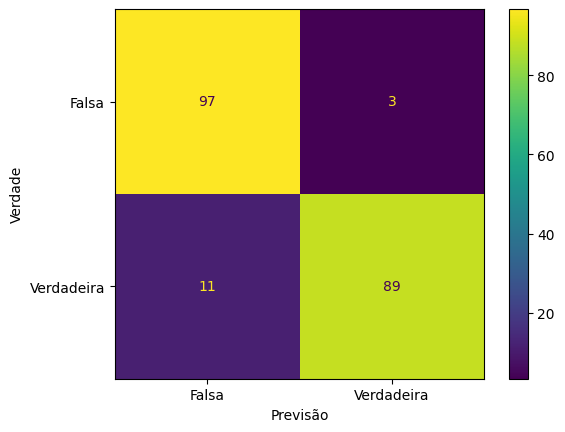

Fim dos testes


In [30]:

print("Inicio do Teste")

y_test_pred = modelLSTM.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.70)
lstm_acc = round(accuracy_score(y_test, y_test_pred) * 100, 2)

cm = confusion_matrix(y_test, y_test_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print(classification_report(y_test, y_test_pred))

print("Matriz de confusão")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falsa','Verdadeira'], )
disp.plot(values_format='.0f')
disp.ax_.set(xlabel='Previsão', ylabel='Verdade')

#plt.savefig('../matriz/confusion_matrix_LSTM%.png')
plt.show()

print("Fim dos testes")

print("=" * 30)




#### RNN (HAN)

Inicio do Teste
68/68 [==============================] - 7s 76ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1080
           1       0.92      0.90      0.91      1080

    accuracy                           0.92      2160
   macro avg       0.92      0.92      0.92      2160
weighted avg       0.92      0.92      0.92      2160

Matriz de confusão


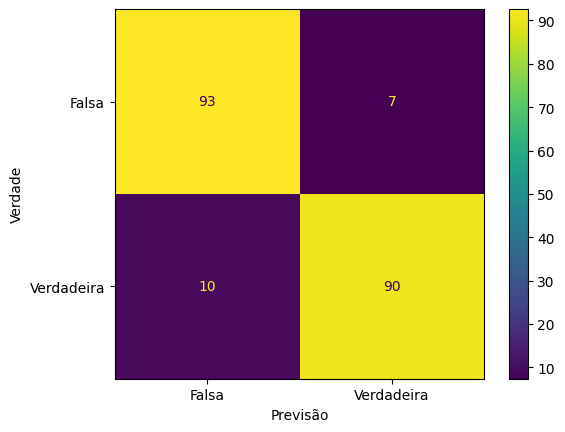

Fim dos testes


In [31]:

print("Inicio do Teste")
y_test_pred = modelHAN.predict(test_padded_seqeunces)
y_test_pred = (y_test_pred > 0.60)
han_acc = round(accuracy_score(y_test, y_test_pred) * 100, 2)
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

print("Matriz de confusão")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Falsa','Verdadeira'], )
disp.plot(values_format='.0f')
disp.ax_.set(xlabel='Previsão', ylabel='Verdade')

#plt.savefig('../matriz/confusion_matrix_HAN%.png')
plt.show()

print("Fim dos testes")


In [32]:

print("=" * 30)

plt.plot(historyHAN.history['loss'])
plt.title('Model loss progress during training')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend(['Training loss'])
#plt.savefig('../graficos/loss_han.png')



NameError: name 'historyHAN' is not defined

In [ ]:

plt.plot(historyHAN.history['accuracy'])
plt.title('Model accuracy progress during training')
plt.xlabel('Epoch')
plt.ylabel('Training accuracy')
plt.legend(['Training accuracy'])
#plt.savefig('../graficos/accuracy_han.png')



In [ ]:
plot_model(model_han, to_file='../summery/han.png', show_shapes=True, show_layer_names=True)

In [ ]:
mlpG_train =  round(clp.best_score_ * 100, 0)
mlp_acc =  round(clp.best_estimator_.score(X_test, y_test) * 100, 0)
LSTM_train = round(historyLSTM.history['accuracy'][-1] * 100, 0)
lstm_acc = round(accuracy_score(y_test, y_test_pred) * 100, 0)
HAN_train = round(historyHAN.history['accuracy'][-1] * 100, 0)
han_acc = round(accuracy_score(y_test, y_test_pred) * 100, 0)


NameError: name 'clp' is not defined

In [ ]:
model = pd.DataFrame({
    'Model': [
        'MLP',
        'RNN LSTM(BI)',
        'HAN'
    ],
    'Train Accuracy Score': [
        
        mlpG_train ,LSTM_train,HAN_train
    ],
    'Test Accuracy': [
        
        mlp_acc ,lstm_acc,han_acc
    ]
})

In [ ]:
Train = model.sort_values('Test Accuracy',ascending=False)
Train